[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Humboldt-WI/bads/blob/master/tutorials/6_nb_model_assessment.ipynb) 


# Predictive Analytics I
We have learned about logistic regression and CART. Equipped with this knowledge, we can move on with revisiting practices to evaluate supervised learning models. Today, we focus on the assessment of predictive accuracy. Remember that accuracy is not the only relevant dimension of model performance. Also remember that both logit and CART could also be employed for *explanatory* modeling, which would imply use of yet different evaluation criteria. Here, however, we focus on prediction. Further, we will focus on models for classification. Measuring the predictive accuracy of a regression model is straightforward and involves calculating indicators such as MSE, MAE, MAPE, and the like. Once you can assess a classification model, you will have no problems with assessing a regression model.  

Here are some key things we address:
- Model evaluation

- Some Ensemble Learning

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from sklearn.model_selection import train_test_split

# Some configuration of the plots we will create later
%matplotlib inline  
plt.rcParams["figure.figsize"] = (12,6)

## Data
Also as usual, we need some data to play with. Given our focus on classification and given that we know the data quite well by now, we will continue with the **HMEQ data set**. 

In [2]:
df = pd.read_csv('../data/hmeq_modeling.csv', index_col="index")

# Split data into target and features
pd_X = df.drop(['BAD'], axis=1) 
pd_y = df['BAD'].astype(int)  # also make the target an integer value

# no dev set this time, we will use cross-validation on the train data
X_train, X_test, y_train, y_test = train_test_split( pd_X, pd_y, test_size=0.3, random_state=42)


df.head(5) 

,BAD,LOAN,MORTDUE,VALUE,YOJ,CLAGE,NINQ,CLNO,DEBTINC,DEROGzero,REASON_HomeImp,REASON_IsMissing,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self,DELINQcat_1,DELINQcat_1+
index,,,,,,,,,,,,,,,,,,,
0,True,-1.832283,-1.295882,-1.335526,0.266788,-1.075278,-0.065054,-1.297476,0.137456,True,1,0,0,1,0,0,0,0,0
1,True,-1.810666,-0.013474,-0.672699,-0.236615,-0.723092,-0.826792,-0.756608,0.137456,True,1,0,0,1,0,0,0,0,1
2,True,-1.789048,-1.654549,-1.839275,-0.668103,-0.368769,-0.065054,-1.189302,0.137456,True,1,0,0,1,0,0,0,0,0
3,True,-1.789048,-0.159552,-0.202559,-0.236615,-0.061033,-0.065054,-0.107566,0.137456,True,0,1,0,1,0,0,0,0,0
4,False,-1.767431,0.791699,0.311107,-0.811933,-1.088528,-0.826792,-0.756608,0.137456,True,1,0,1,0,0,0,0,0,0


## Prediction models
Finally, since we aim at assessing predictions, we need to obtain some predictions in the first place. Let's quickly build a logit and a tree model for our data. 

In [3]:
# Estimate a logit model
from sklearn.linear_model import LogisticRegression

logit = LogisticRegression(penalty='none', fit_intercept=True)
logit.fit(X_train, y_train)

LogisticRegression(penalty='none')

In [4]:
# Estimate a CART tree
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', max_depth=5)
tree.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5)

# Forecast accuracy in classification

## Continuous and discrete predictions
To generate prediction from a trained model, we simply apply it to data. You already know the `predict()` function in action.

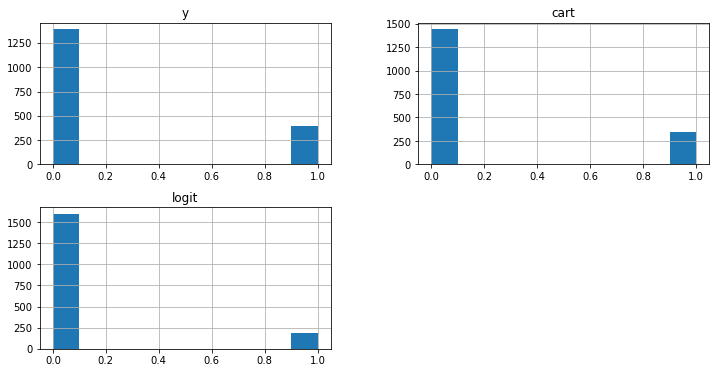

In [5]:
# We collect predictions into a dataframe for easy visualization
df_pred = pd.DataFrame({'y': y_test, 'cart': tree.predict(X_test), 'logit': logit.predict(X_test)})  
df_pred.hist();

How to interpret these graphs? Well, many points are noteworthy:
- the data is imbalanced, $y$ shows less ones (bad clients) than zeros (good clients).
- CART and logit pick-up the imbalance and predict class 0 more often.
- CART and logit indeed predict classes. All predictions are either zero or one, and never anything in between.

Given the latter point, let's create some probabilistic predictions using the function `predict_proba()`. Remember that `sklearn` classification models routinely offer both functions, `predict()` and `predict_proba()`, for producing discrete and probabilistic predictions, respectively.

In [6]:
# Add probabilistic predictions to our dataframe
p = logit.predict_proba(X_test)
print(p)  # this is a 2D array

[[0.93186683 0.06813317]
 [0.93798714 0.06201286]
 [0.73778796 0.26221204]
 ...
 [0.96003058 0.03996942]
 [0.85082524 0.14917476]
 [0.52209895 0.47790105]]


Note that the result `p`, which we compute above, is an $n \times 2$ array. An array was to be expected as we calculate predictions for the $n$ data instances (rows) in $X$. But why have two outputs per data instance? Well, the answer is that we have two classes, and get probability estimates for each of these classes. When storing model predictions for later use, we only need the probabilities for one of the classes. Always make sure you **understand which class predictions you keep.** Examining the `classes_` attribute of a model class helps us.   

In [7]:
print(logit.classes_)

[0 1]


This says that we have two classes with class labels zero and one, respectively. Thus, to extract the estimated probabilities of the class with label zero, we can call `p[:,0]`. Likewise, `p[:,1]` gives the estimated membership probabilities of the second class with the label one. This is a bit complicated in the beginning but we have to get used to it. Below, we combine the indexing directly with calling `predict_proba()`, which is common practice, and keep the predictions associated with the second class. In our data, the class label one indicates that a borrower was a bad risk.

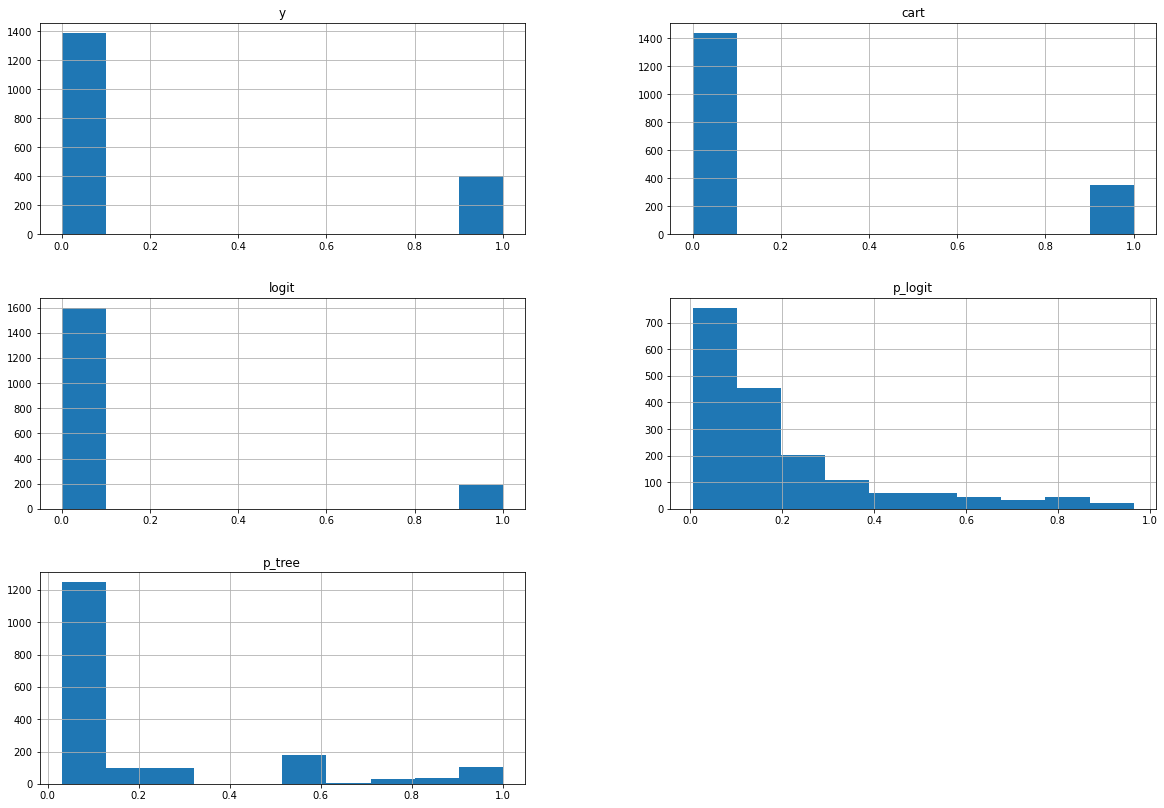

In [8]:
# Augment data frame with predictions
df_pred["p_logit"] = p[:,1]
df_pred["p_tree"] = tree.predict_proba(X_test)[:,1]

# Also plot the probabilistic predictions
df_pred.hist(figsize=(20,14));

Did you notice the different distribution of the predictions from the logit model compared to the tree model in the histograms? One could draw several conclusions from the plots. Make sure to think about and understand the following statement:

*The number of distinct values among the probability estimates coming from the tree is upper bounded by (and often equivalent to) the number of leaf nodes in a classification tree*

We will not elaborate on that statement here, but, at least, verify the claim empirically.

In [9]:
# Calculate the number of distinct values among the tree predictions
n_p_tree =  len(np.unique(df_pred["p_tree"]))
print('The number of unique predictions from the tree is: {}.'.format(n_p_tree))

# Extract the size of the tree in terms of the number of nodes
print('The number of leaf nodes in the tree is: {}.'.format(tree.get_n_leaves()))


The number of unique predictions from the tree is: 15.
The number of leaf nodes in the tree is: 23.


So here, there are more leaf nodes than unique predictions, which is consistent with the above statement. Why does it has to be like that? Fair enough if you find the question trivial, but we want to make sure you fully understand how trees predict probabilities. 

## Measures of predictive accuracy 
Accuracy indicators help us evaluate how well our model predicts the target. We compute them by **comparing actuals to predictions**. One easy way to do so is by using the `score()` function.

In [10]:
print('Logit model scores {:.4}'.format(logit.score(X_test, y_test)))
print('Tree model scores {:.4}'.format(tree.score(X_test, y_test)))

Logit model scores 0.8121
Tree model scores 0.882


Wow, so easy. Really? Yes! But what actually is that score? Are higher scores better or should the score be low? We call functions like `score()` convenience functions. They are easy to use but hide many - often important - details. Look into the help to see what `score()` is really computing. 

Ok, **after reading the help** you now know that `score()` calculates *classification accuracy*. We defined that measure in the lecture as
$$ \frac{TP+TN}{TP+TN+FP+FN}$$
whereby the TP, TN, FP, and FP denote, respectively, the number of true positive, true negative, false positive, and false negative classifications. Let's revisit the calculation in Python.

In [11]:
# Re-calc accuracy of logit
acc = np.sum(logit.predict(X_test)==y_test) / len(y_test)  # just one way to do the calculation
print("Manually calculated accuracy: {:.4}".format(acc))

Manually calculated accuracy: 0.8121


Ok that worked out. Now remember that we were rather critical with classification accuracy in the lecture. Let's revisit why we do not like this measure.

Classification accuracy is a **threshold metric**. It calculates model performance for one threshold or classification cut-off. If not specified, this threshold is usually set to 0.5. That's also what the `predict()` function does. Changing the threshold can change classification accuracy a lot although the model stays the same. This is particularly true for imbalanced data sets like this one. Let me give you an exemplary scenario: We have 100 observations. 5 observations are of the class 'BAD' and 95 of the class 'GOOD'. So even without finding any generalizable patterns, classifying all observations as good would still result in an accuracy of 95%. To ensure robustness of our model, we want to avoid dependence of a performance measure on the cut-off.

A preferable approach to assess classification performance is to consider all possible thresholds. This is what *receiver-operating-characteristics (ROC) analysis* does. Before looking into ROC, let's have a look at the full confusion table first, which will also remind us of the role of the threshold.

### Confusion matrix
A confusion matrix is a cross-table of predicted and actual classes. As such, it provides more insight into a classifier compared to the classification accuracy measure, which summarizes the whole confusion table in a single number.

In [12]:
from sklearn import metrics  # Important lib where we find various performance measures

# 1. Quick and dirty way to get a confusion table
cmat = metrics.confusion_matrix(y_test, logit.predict(X_test)) 
print(cmat)

[[1326   63]
 [ 273  126]]


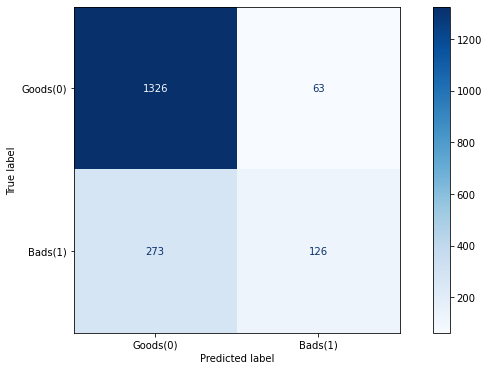

In [13]:
# 2. Pretty-print confusion matrix
metrics.plot_confusion_matrix(logit, X_test, y_test, labels=[0, 1], 
                              display_labels=['Goods(0)', 'Bads(1)'], cmap='Blues',values_format='n')
plt.show()

Classification accuracy simply calculates the number of correct class predictions (main diagonal) over all cases. Correct predictions are twofold. We can classify a good customer as good customer and we can classify a bad customer as bad customer. Likewise, our classifier can make two errors, classifying an actually good customer as bad and classifying an actually bad customer as good. We find the numbers of these errors in the off-diagonal of the confusion matrix. Which class a model predicts depends on the classification threshold. You classify cases as BAD if $p(y=BAD|x) \gt \tau$, and as GOOD otherwise, whereby $\tau$ denotes the threshold. 

Hence, the above **confusion table is based on one threshold**. It might look rather different for another threshold. A ROC curve considers all cut-offs $\tau \in [0,1]$ plotting the **True Positive Rate** and **False Positive Rate** for each threshold. Given that ROC analysis is a general tool for binary classification and used in various domains, people came up with a standardized terminology to refer to the classes. Instead of speaking about goods and bads (i.e., credit scoring jargon) or zeros and ones (which is likely to offend members of the former group), we refer to the classes as the *positive* and the *negative* class. Thus, the TPR is the fraction cases that the classifier predicts to be of class positive and that actually belong to that class. The true negative rate or TNR is defined alike. For the two errors, we have the false positive rate (FPR) and the false negative rate (FNR). Correct interpretation of these errors is maybe a little difficult. How about false positives? The classifier predicts class positive but the prediction is false. Such a case actually belongs to the negative class. So the FPR is the fraction of cases that the classifier predicts as positives and that actually are negatives. The same argumentation goes for the FNR.  

In cases with highly imbalanced class distribution (like the credit dataset at hand) it can be very instructive to look at the balanced accuracy. The balanced accuracy re-weights the individual class accuracies to balance them out.

In [23]:
# the balanced accuracy:
print('logistic regr bal. acc score on test: ' +  str(
    metrics.balanced_accuracy_score(y_test, logit.predict(X_test))) )
print('tree bal. acc score on test: ' +  str(
    metrics.balanced_accuracy_score(y_test, tree.predict(X_test))) )

logistic regr bal. acc score on test: 0.6352165510969648
tree bal. acc score on test: 0.8079350644429648


Quite the difference for the logistic regresssion!

### ROC Curve and AUC

This is one of the most important evaluation metrics in classification analysis. Have a look at the graph below. The curve tells us how well the model differentiates the two classes. A ROC curve has the FPR on the X-axis and TPR on the Y-axis. The curve is derived from all the different combinations of TPR and FPR (i.e., confusion tables) across all possible thresholds $0 \le  \tau \le 1$ (assuming we have probabilistic predictions).

The AUC stand for the area under the curve and is a ranking indicator. The AUC estimates the probability that a randomly chosen positive instance is correctly ranked higher than a randomly chosen negative instance (Hanley and McNeil, 1983). Being a probability, it is clear that the AUC is between $\left[ 0,1 \right]$. 

Our goal is to have a FPR of 0 and a TPR of 1. This would be the perfect model. We find the corresponding point in the top right corner of the ROC curve. The closer we get to that point, the better the classifier and the bigger the area under the ROC curve. It is common practice to add a horizontal line to the plot. You can show that this line corresponds to a random classifier. So any serious classifier should give a ROC curve (much) above the horizontal line. This also implies that a classifier should display AUC (much) bigger than 0.5.

Below we show different ways to plot the ROC curve.

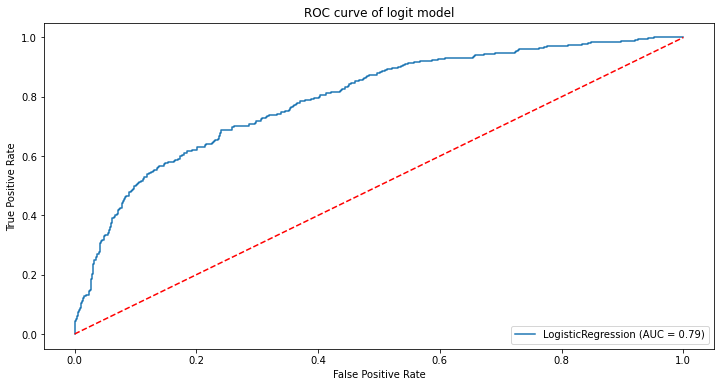

In [14]:
# Sklear offers an easy-to-use function to produce a ROC curve. 
metrics.plot_roc_curve(logit, X_test, y_test)
plt.title('ROC curve of logit model')
plt.plot([0, 1], [0, 1], "r--");  #  we need to add the random benchmark manually

You will also want to look into other metrics from time to time. We will discuss some of them. Check sklearn's documentation of metrics at

https://scikit-learn.org/stable/modules/model_evaluation.html

Noteworthy metrics for model assessment in our example are the F1 score as well as the balanced accuracy. 

## Model Selection via Cross-validation
Cross validation is an extension of the split sample method. It consists of repeating the train data split multiple times.

Step by step:
- Randomly split training data in N disjoint folds (E.g., N=5) 
- Build model on N-1 folds 
- Apply trained model to produce predictions for cases in the left-out fold (i.e., validation sample) 
- Measure model performance by comparing actuals to predictions using the validation sample
- Repeat the above steps N times 
- Average model performance over the N validation folds  
- You can also estimate the standard deviation of model performance (e.g., for statistical hypothesis testing)

Unlike the split sample (holdout) approach, cross-validation considers all training (plus validation/development) data for model building and validation and is, therefore, more efficient in its use of the available data. It's called exhaustive for this reason. 

### A first look into ensemble learning

Let's try to improve the predictive power of tree-based classifiers through ensemble learning.  An ensemble is a collection of multiple base models. The base models are prediction models on their own. In a homogeneous ensemble, one produces the base models with the same supervised learning algorithm. Our underlying learning algorithm will be a classification tree.

### Random Forest Hyperparameter Tuning with CV

Even more effective for predictions than decision trees, random forests (RF) are useful and powerful ensemble methods for classifying and regressing data. Essentially, a random set of the features are taken to build decision trees. Trees are also built using *bagged data* which are samples of the data taken with replacement. Many trees are grown (sometimes their maximum depth is also specified) and then all trees vote on the response. Each tree's vote generally has the same weight.

**Some more detail copied from the sklearn documentation**:

1.11.2.1. Random Forests
In random forests (see RandomForestClassifier and RandomForestRegressor classes), each tree in the ensemble is built from a sample drawn with replacement (i.e., a bootstrap sample) from the training set.

Furthermore, when splitting each node during the construction of a tree, the best split is found either from all input features or a random subset of size max_features. (See the parameter tuning guidelines for more details).

The purpose of these two sources of randomness is to decrease the variance of the forest estimator. Indeed, individual decision trees typically exhibit high variance and tend to overfit. The injected randomness in forests yield decision trees with somewhat decoupled prediction errors. By taking an average of those predictions, some errors can cancel out. Random forests achieve a reduced variance by combining diverse trees, sometimes at the cost of a slight increase in bias. In practice the variance reduction is often significant hence yielding an overall better model.

In contrast to the original publication, the scikit-learn implementation combines classifiers by averaging their probabilistic prediction, instead of letting each classifier vote for a single class.

Tuning random forest classifier
Fitting 5 folds for each of 9 candidates, totalling 45 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  45 out of  45 | elapsed:   31.3s finished


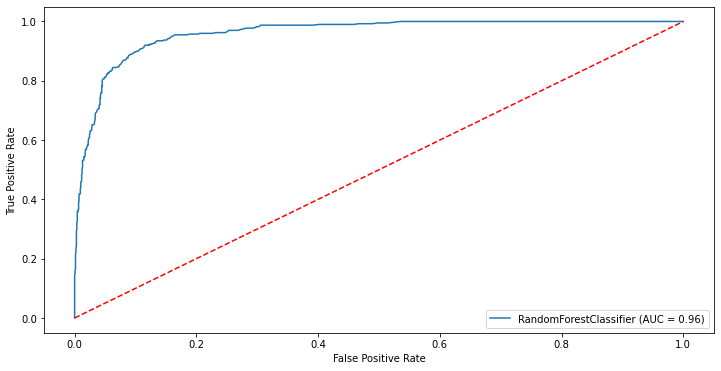

In [15]:
from sklearn.ensemble import RandomForestClassifier  # import library
from sklearn.model_selection import GridSearchCV

print('Tuning random forest classifier')
rf = RandomForestClassifier(random_state=888, max_samples = 0.5)  # This way, bootstrap sample size will be 50% of the training set

# Define meta-parameter grid of candidate settings
# The following settings are just for illustration
param_grid = {'n_estimators': [100, 200, 500],
              'max_depth': [10, 20, 30]
              }

# Set up the grid object specifying the tuning options
gs_rf = GridSearchCV(rf, param_grid, cv=5, scoring='roc_auc', verbose=1)
gs_rf.fit(X_train, y_train.values.ravel())

# plot the roc curve for the best forest: gs_rf.best_estimator_ 
metrics.plot_roc_curve(gs_rf.best_estimator_, X_test, y_test)
plt.plot([0, 1], [0, 1], "r--");

In [16]:
# but what are the optimal params (as per CV)?
gs_rf.best_params_

{'max_depth': 30, 'n_estimators': 500}

In [17]:
# The CV results in detail
#gs_rf.cv_results_

# the param grid:
print(gs_rf.cv_results_['param_max_depth'].data)
print(gs_rf.cv_results_['param_n_estimators'].data)

# the final ranking
print(gs_rf.cv_results_['rank_test_score'])

[10 10 10 20 20 20 30 30 30]
[100 200 500 100 200 500 100 200 500]
[9 8 7 5 4 2 6 3 1]


Let's check the performance vs logistic reg and the plain vanilla decision tree. Eyeballing the ROC curve tells us already that the Random Forest should win...

In [19]:
print('dec. tree regr ROCAUC score on test: ' +  str(metrics.roc_auc_score(y_test, tree.predict_proba(X_test)[:,1])) )
print('logistic regr ROCAUC score on test: ' +  str(metrics.roc_auc_score(y_test, logit.predict_proba(X_test)[:,1])) )
print('random forest ROCAUC score on test: ' +  str(metrics.roc_auc_score(y_test, gs_rf.predict_proba(X_test)[:,1])) )

dec. tree regr ROCAUC score on test: 0.8747002495439462
logistic regr ROCAUC score on test: 0.7926980879123655
random forest ROCAUC score on test: 0.9603562542064304


... and it does. It generalizes much better than both the logistic regression and the decision tree. 

## A Note on Overfitting 

To see a really good example of a model that can easily be overfit, we can take a look at decision trees. Decision trees are rather complex and highly nonlinear models. When trees are grown too deep, they start to internalize idiosyncacies (noise) of the specific data that they were fed. This means that they "assume" that all little random variations in the train data will occur in test sets as well.

Let's take a look at what this looks like by generating a tracking the AUC of a decision tree on training and test data as we increase the **depth** of the tree.

In [34]:
from sklearn import tree

train_auc_list = []
test_auc_list = []

for n in range(1,30):
  # Fit tree to training data
  dt = tree.DecisionTreeClassifier(max_depth=n, random_state=888)
  dt = dt.fit(X_train, y_train)
  
  # Predictions and metrics for training data
  dt_train_pred = dt.predict(X_train)
  auc = metrics.roc_auc_score(y_train, dt_train_pred)
  train_auc_list.append(auc)
  
  # Predictions and metrics for test data
  dt_test_pred = dt.predict(X_test)
  auc = metrics.roc_auc_score(y_test, dt_test_pred)
  test_auc_list.append(auc)

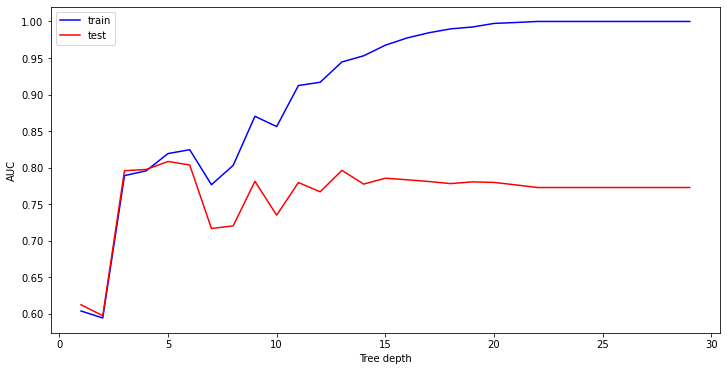

In [35]:
plt.plot(range(1,30), train_auc_list, c='b', label="train")
plt.plot(range(1,30), test_auc_list, c='r', label="test")
plt.ylabel("AUC")
plt.xlabel("Tree depth")
plt.legend(loc="best")
plt.show()

Almost textbook! Apparently an ever increasing complexity (tree depth) does not lead to better generalization. Instead, the optimal tree depth that gives good generalization on the test dataset is around 5. 